In [1]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [2]:
import os
import time

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"

import warnings
from pathlib import Path

import humanize
from darts.metrics import mae, mase, mse
from sklearn.preprocessing import StandardScaler
from src.forecasting.ml_forecasting import (
    FeatureConfig,
    MissingValueConfig,
    MLForecast,
    ModelConfig,
    calculate_metrics,
)
from src.utils import plotting_utils
from src.utils.general import LogTime
from src.utils.ts_utils import darts_metrics_adapter, forecast_bias
from tqdm.autonotebook import tqdm

%load_ext autoreload
%autoreload 2
np.random.seed(42)
tqdm.pandas()

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-\src\utils\data_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_7", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")

In [4]:
def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        )
    )
    return fig

In [5]:
#Readin the missing value imputed and train test split data
train_df = pd.read_parquet(preprocessed/"block_0-7_train_missing_imputed_feature_engg.parquet")
# Read in the Validation dataset as test_df so that we predict on it
test_df = pd.read_parquet(preprocessed/"block_0-7_val_missing_imputed_feature_engg.parquet")
# test_df = pd.read_parquet(preprocessed/"block_0-7_test_missing_imputed_feature_engg.parquet")

In [10]:
subset = ['block_0', 'block_1', 'block_2', 'block_3']

In [11]:
train_df = train_df[train_df.file.isin(subset)]
test_df = test_df[test_df.file.isin(subset)]

### Loading the single step backtesting baselines for validation

In [6]:
baseline_metrics_df = pd.read_pickle(output/"ml_single_step_metrics_auto_stationary_test_df.pkl")
baseline_aggregate_metrics_df = pd.read_pickle(output/"ml_single_step_aggregate_metrics_auto_stationary_test.pkl")
# baseline_metrics_test_df = pd.read_pickle(output/"single_step_backtesting_baseline_metrics_test_df.pkl")
# baseline_aggregate_metrics_test_df = pd.read_pickle(output/"single_step_backtesting_baseline_aggregate_metrics_test.pkl")

In [12]:
len(train_df.LCLid.unique())

200

# Feature Definition

In [13]:
feat_config = FeatureConfig(
    date="timestamp",
    target="energy_consumption",
    continuous_features=[
        "visibility",
        "windBearing",
        "temperature",
        "dewPoint",
        "pressure",
        "apparentTemperature",
        "windSpeed",
        "humidity",
        "energy_consumption_lag_1",
        "energy_consumption_lag_2",
        "energy_consumption_lag_3",
        "energy_consumption_lag_4",
        "energy_consumption_lag_5",
        "energy_consumption_lag_49",
        "energy_consumption_lag_50",
        "energy_consumption_lag_51",
        "energy_consumption_lag_52",
        "energy_consumption_lag_53",
        "energy_consumption_rolling_3_mean",
        "energy_consumption_rolling_3_std",
        "energy_consumption_rolling_6_mean",
        "energy_consumption_rolling_6_std",
        "energy_consumption_rolling_12_mean",
        "energy_consumption_rolling_12_std",
        "energy_consumption_rolling_48_mean",
        "energy_consumption_rolling_48_std",
        "energy_consumption_48_seasonal_rolling_3_mean",
        "energy_consumption_48_seasonal_rolling_3_std",
        "energy_consumption_336_seasonal_rolling_3_mean",
        "energy_consumption_336_seasonal_rolling_3_std",
        "energy_consumption_ewma__span_2880",
        "energy_consumption_ewma__span_336",
        "energy_consumption_ewma__span_48",
        "timestamp_Elapsed",
        "timestamp_Month_sin_1",
        "timestamp_Month_sin_2",
        "timestamp_Month_sin_3",
        "timestamp_Month_sin_4",
        "timestamp_Month_sin_5",
        "timestamp_Month_cos_1",
        "timestamp_Month_cos_2",
        "timestamp_Month_cos_3",
        "timestamp_Month_cos_4",
        "timestamp_Month_cos_5",
        "timestamp_Hour_sin_1",
        "timestamp_Hour_sin_2",
        "timestamp_Hour_sin_3",
        "timestamp_Hour_sin_4",
        "timestamp_Hour_sin_5",
        "timestamp_Hour_cos_1",
        "timestamp_Hour_cos_2",
        "timestamp_Hour_cos_3",
        "timestamp_Hour_cos_4",
        "timestamp_Hour_cos_5",
        "timestamp_Minute_sin_1",
        "timestamp_Minute_sin_2",
        "timestamp_Minute_sin_3",
        "timestamp_Minute_sin_4",
        "timestamp_Minute_sin_5",
        "timestamp_Minute_cos_1",
        "timestamp_Minute_cos_2",
        "timestamp_Minute_cos_3",
        "timestamp_Minute_cos_4",
        "timestamp_Minute_cos_5",
    ],
    categorical_features=[
        "stdorToU",
        "Acorn",
        "Acorn_grouped",
        "holidays",
        "precipType",
        "icon",
        "summary",
        "timestamp_Month",
        "timestamp_Quarter",
        "timestamp_WeekDay",
        "timestamp_Dayofweek",
        "timestamp_Dayofyear",
        "timestamp_Hour",
        "timestamp_Minute",
    ],
    boolean_features=[
        "timestamp_Is_quarter_end",
        "timestamp_Is_quarter_start",
        "timestamp_Is_year_end",
        "timestamp_Is_year_start",
        "timestamp_Is_month_start",
    ],
    index_cols=["timestamp"],
    exogenous_features=[
        "holidays",
        "precipType",
        "icon",
        "summary",
        "visibility",
        "windBearing",
        "temperature",
        "dewPoint",
        "pressure",
        "apparentTemperature",
        "windSpeed",
        "humidity",
    ],
)

# Missing Value Handling

In [14]:
missing_value_config = MissingValueConfig(
    bfill_columns=[
        "energy_consumption_lag_1",
        "energy_consumption_lag_2",
        "energy_consumption_lag_3",
        "energy_consumption_lag_4",
        "energy_consumption_lag_5",
        "energy_consumption_lag_49",
        "energy_consumption_lag_50",
        "energy_consumption_lag_51",
        "energy_consumption_lag_52",
        "energy_consumption_lag_53",
        "energy_consumption_rolling_3_mean",
        "energy_consumption_rolling_3_std",
        "energy_consumption_rolling_6_mean",
        "energy_consumption_rolling_6_std",
        "energy_consumption_rolling_12_mean",
        "energy_consumption_rolling_12_std",
        "energy_consumption_rolling_48_mean",
        "energy_consumption_rolling_48_std",
        "energy_consumption_48_seasonal_rolling_3_mean",
        "energy_consumption_48_seasonal_rolling_3_std",
        "energy_consumption_336_seasonal_rolling_3_mean",
        "energy_consumption_336_seasonal_rolling_3_std",
        "energy_consumption_ewma__span_2880",
        "energy_consumption_ewma__span_336",
        "energy_consumption_ewma__span_48",
    ],
    ffill_columns=[],
    zero_fill_columns=[],
)

# Running Global ML models

In [15]:
train_features, train_target, train_original_target = feat_config.get_X_y(
    train_df, categorical=True, exogenous=True
)
# Loading the Validation as test
test_features, test_target, test_original_target = feat_config.get_X_y(
    test_df, categorical=True, exogenous=True
)

In [16]:
del train_df, test_df

In [22]:
train_features.columns

Index(['visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity',
       'energy_consumption_lag_1', 'energy_consumption_lag_2',
       'energy_consumption_lag_3', 'energy_consumption_lag_4',
       'energy_consumption_lag_5', 'energy_consumption_lag_49',
       'energy_consumption_lag_50', 'energy_consumption_lag_51',
       'energy_consumption_lag_52', 'energy_consumption_lag_53',
       'energy_consumption_rolling_3_mean', 'energy_consumption_rolling_3_std',
       'energy_consumption_rolling_6_mean', 'energy_consumption_rolling_6_std',
       'energy_consumption_rolling_12_mean',
       'energy_consumption_rolling_12_std',
       'energy_consumption_rolling_48_mean',
       'energy_consumption_rolling_48_std',
       'energy_consumption_48_seasonal_rolling_3_mean',
       'energy_consumption_48_seasonal_rolling_3_std',
       'energy_consumption_336_seasonal_rolling_3_mean',
       'energy_consumption_336_seasonal_roll

In [23]:
lags_seasonality = 

['timestamp_Is_quarter_end',
 'timestamp_Is_quarter_start',
 'timestamp_Is_year_end',
 'timestamp_Is_year_start',
 'timestamp_Is_month_start']

In [17]:
pred_df = pd.concat([train_target, test_target])
metric_record = []

In [18]:
metric_record = (
    baseline_aggregate_metrics_df.iloc[[4]]
    .to_dict(orient="records")
)

In [19]:
def evaluate_model(
    model_config,
    feature_config,
    missing_config,
    train_features,
    train_target,
    test_features,
    test_target,
):
    ml_model = MLForecast(
        model_config=model_config,
        feature_config=feat_config,
        missing_config=missing_value_config,
    )
    ml_model.fit(train_features, train_target)
    y_pred = ml_model.predict(test_features)
    feat_df = ml_model.feature_importance()
    metrics = calculate_metrics(test_target, y_pred, model_config.name, train_target)
    return y_pred, metrics, feat_df


# from itertools import cycle


# def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
#     if forecast_display_names is None:
#         forecast_display_names = forecast_columns
#     else:
#         assert len(forecast_columns) == len(forecast_display_names)
#     mask = ~pred_df[forecast_columns[0]].isnull()
#     colors = [
#         "rgba(" + ",".join([str(c) for c in plotting_utils.hex_to_rgb(c)]) + ",<alpha>)"
#         for c in px.colors.qualitative.Plotly
#     ]
#     act_color = colors[0]
#     colors = cycle(colors[1:])
#     fig = go.Figure()
#     fig.add_trace(
#         go.Scatter(
#             x=pred_df[mask].index,
#             y=pred_df[mask].energy_consumption,
#             mode="lines",
#             line=dict(color=act_color.replace("<alpha>", "0.9")),
#             name="Actual Consumption",
#         )
#     )
#     for col, display_col in zip(forecast_columns, forecast_display_names):
#         fig.add_trace(
#             go.Scatter(
#                 x=pred_df[mask].index,
#                 y=pred_df.loc[mask, col],
#                 mode="lines",
#                 line=dict(dash="dot", color=next(colors).replace("<alpha>", "1")),
#                 name=display_col,
#             )
#         )
#     return fig

## Linear Models

In [20]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV

### Linear Regression

In [21]:
model_config = ModelConfig(
    model=LinearRegression(),
    name="Linear Regression",
    # LinearRegression is sensitive to normalized data
    normalize=True,
    # LinearRegression cannot handle missing values
    fill_missing=True,
)
with LogTime() as timer:
    y_pred, metrics, feat_df = evaluate_model(
        model_config,
        feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        test_target,
    )
metrics["Time Elapsed"] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 1 minute and 50 seconds


ValueError: could not convert string to float: 'Affluent'

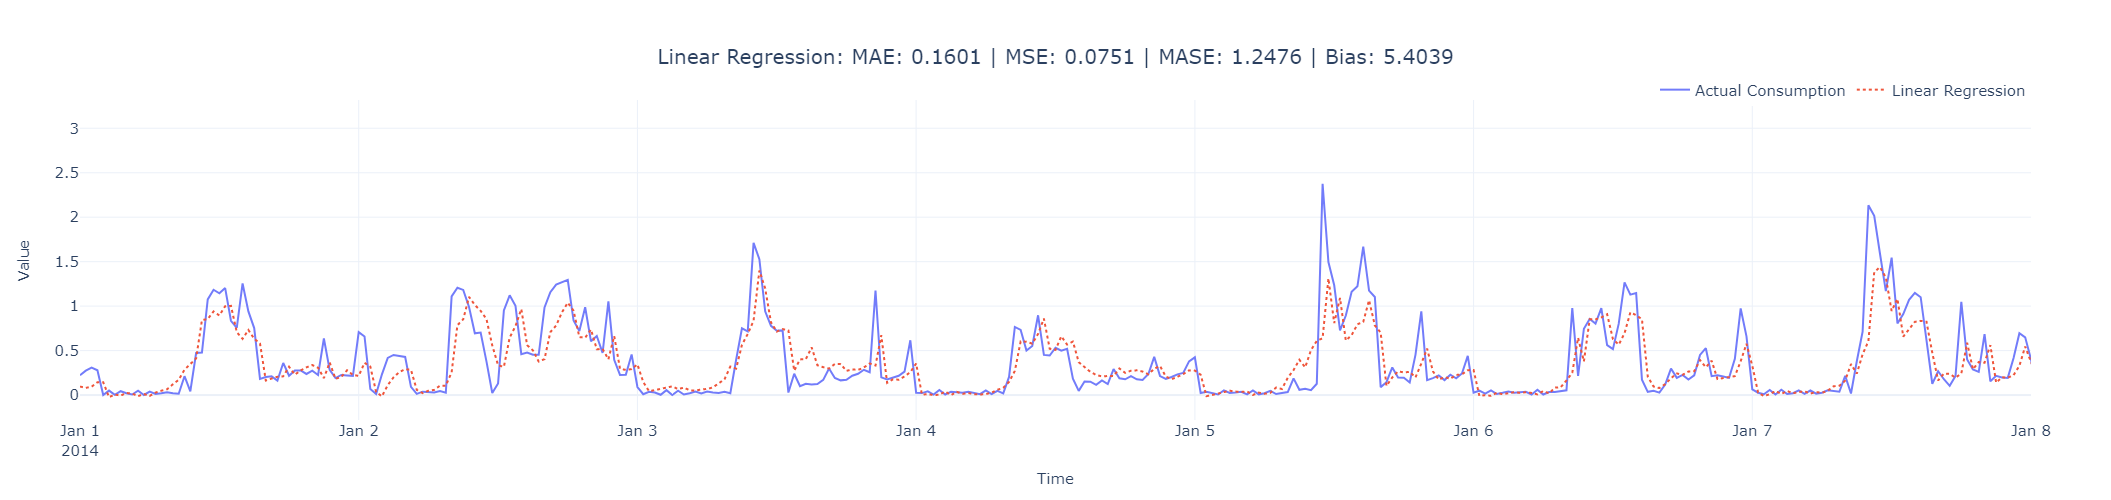

In [17]:
fig = plot_forecast(pred_df, forecast_columns=[model_config.name], forecast_display_names=[model_config.name])
fig = format_plot(fig, title=f"{model_config.name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/lin_reg.png")
fig.show()

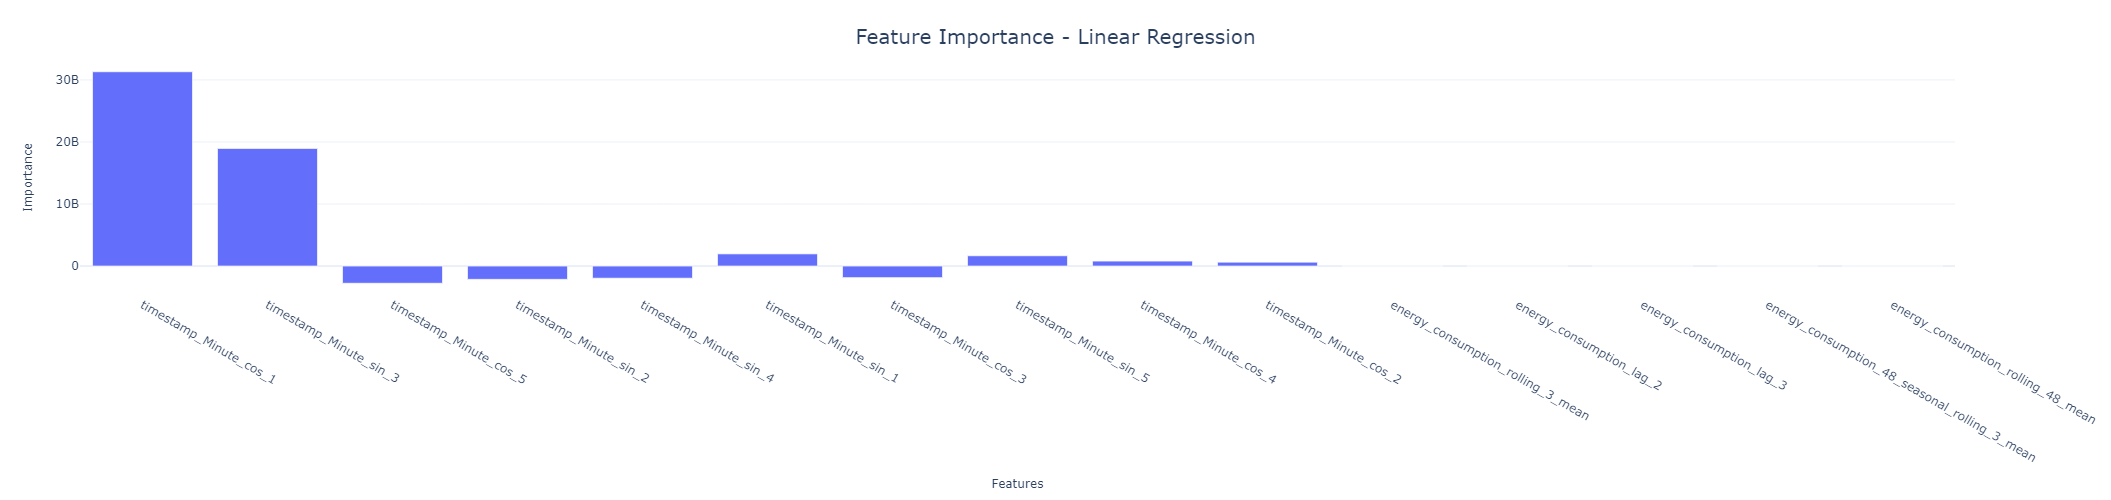

In [19]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_7/lin_reg_fimp.png")
fig.show()

### Ridge Regression (L2)

In [20]:
model_config = ModelConfig(
    model=RidgeCV(), 
    name="Ridge Regression", 
    # RidgeCV is sensitive to normalized data
    normalize=True, 
    # RidgeCV does not handle missing values
    fill_missing=True
)
with LogTime() as timer:
    y_pred, metrics, feat_df = evaluate_model(
        model_config,
        feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        test_target,
    )
metrics["Time Elapsed"] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


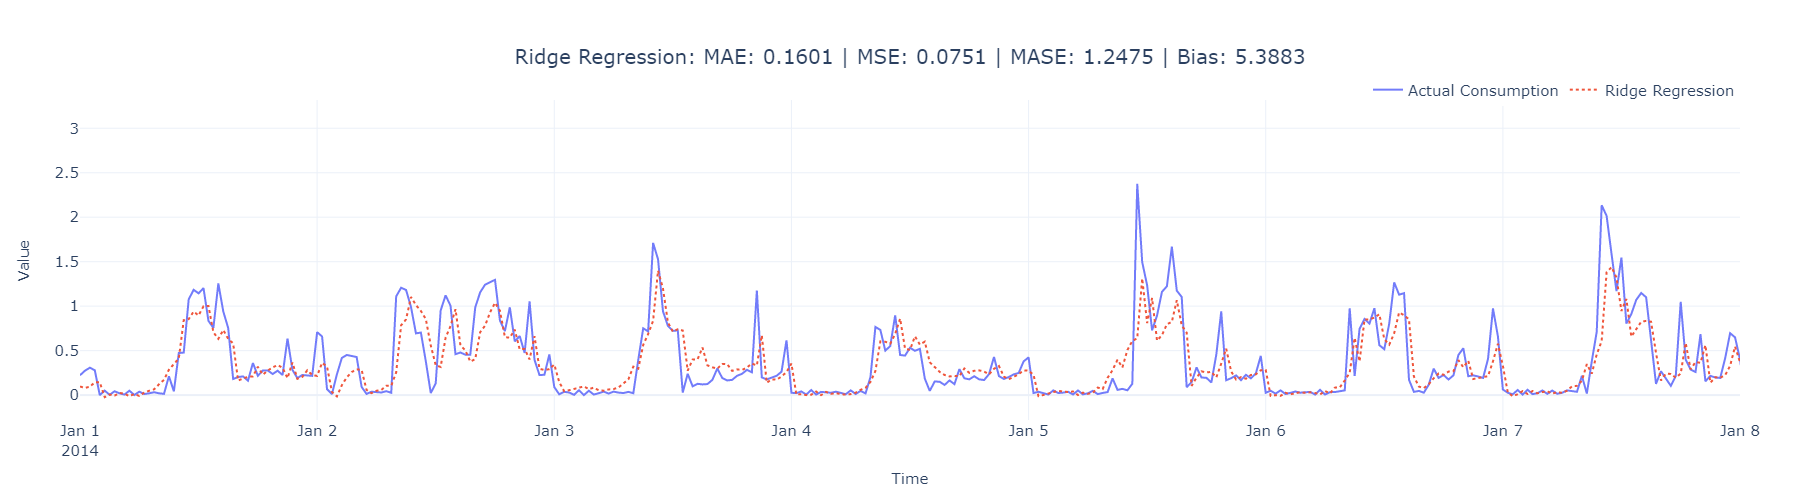

In [21]:
fig = plot_forecast(pred_df, forecast_columns=[model_config.name], forecast_display_names=[model_config.name])
fig = format_plot(fig, title=f"{model_config.name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/ridge_reg.png")
fig.show()

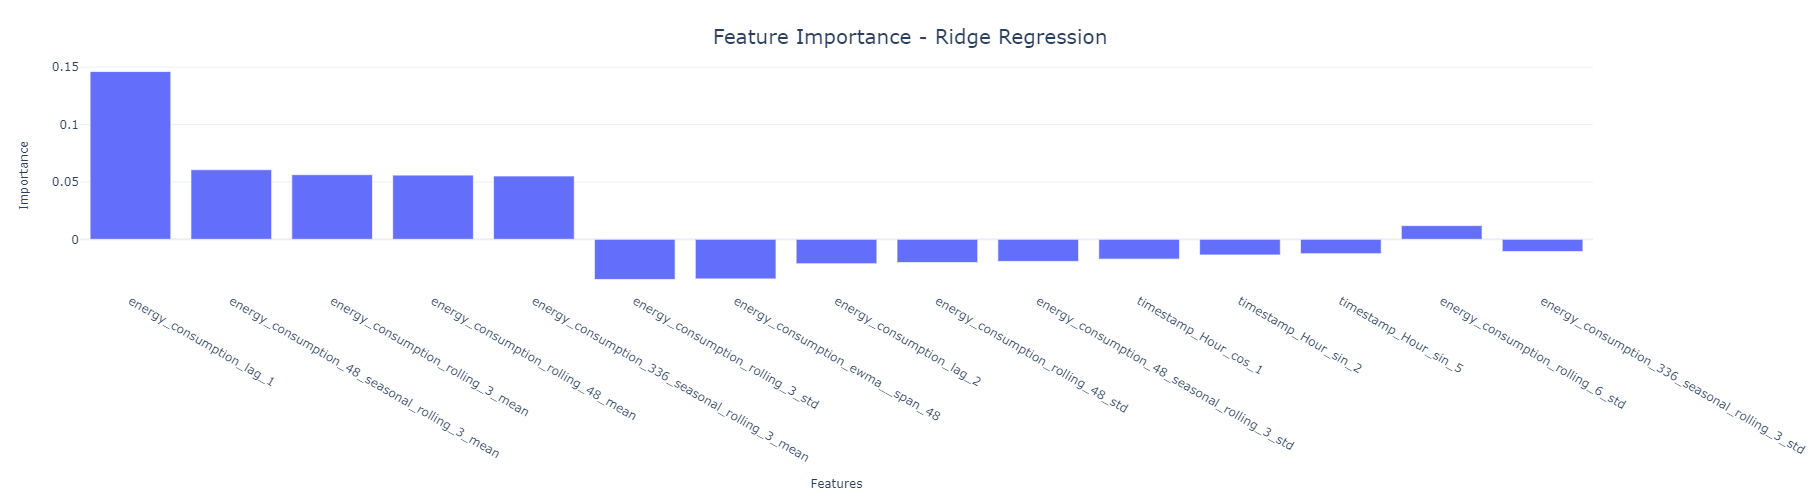

In [22]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_7/ridge_reg_fimp.png")
fig.show()

### Lasso Regression (L1)

In [23]:
model_config = ModelConfig(
    model=LassoCV(), 
    name="Lasso Regression", 
    # LassoCV is sensitive to normalized data
    normalize=True, 
    # LassoCV does not handle missing values
    fill_missing=True
)
with LogTime() as timer:
    y_pred, metrics, feat_df = evaluate_model(
        model_config,
        feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        test_target,
    )
metrics["Time Elapsed"] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

C:\Users\ManuJoseph\miniconda3\envs\modern_ts\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1572: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Time Elapsed: 0 microseconds


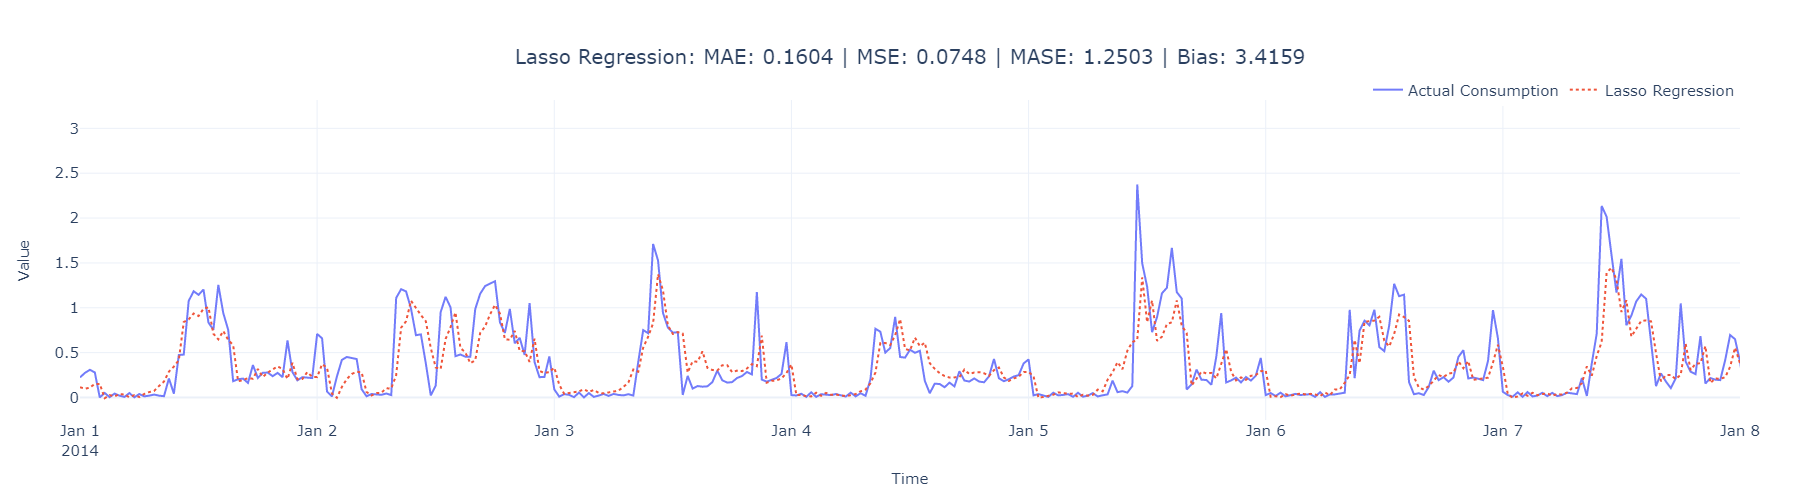

In [24]:
fig = plot_forecast(pred_df, forecast_columns=[model_config.name], forecast_display_names=[model_config.name])
fig = format_plot(fig, title=f"{model_config.name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/lasso_reg.png")
fig.show()

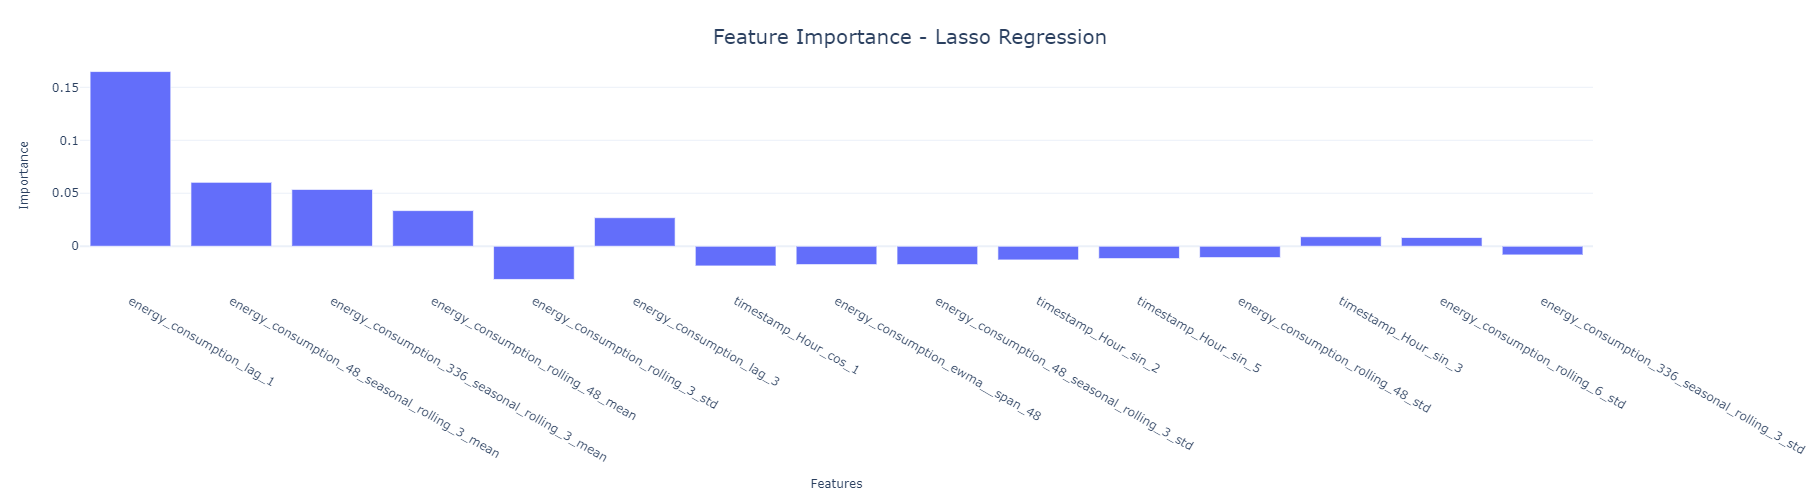

In [25]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_7/lasso_reg_fimp.png")
fig.show()

## Decision Tree

In [26]:
from sklearn.tree import DecisionTreeRegressor

In [27]:
model_config = ModelConfig(
    model=DecisionTreeRegressor(max_depth=4, random_state=42),
    name="Decision Tree",
    # Decision Tree is not affected by normalization
    normalize=False,
    # Decision Tree in scikit-learn does not handle missing values
    fill_missing=True,
)
with LogTime() as timer:
    y_pred, metrics, feat_df = evaluate_model(
        model_config,
        feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        test_target,
    )
metrics["Time Elapsed"] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


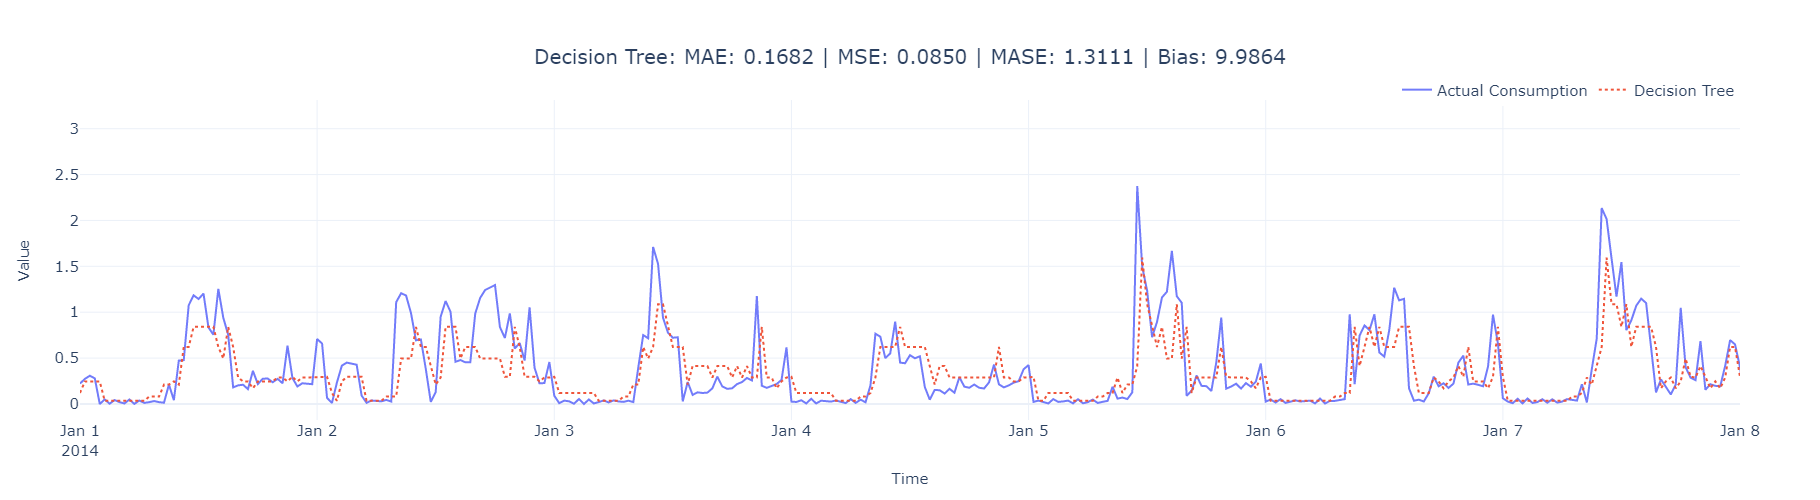

In [28]:
fig = plot_forecast(pred_df, forecast_columns=[model_config.name], forecast_display_names=[model_config.name])
fig = format_plot(fig, title=f"{model_config.name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/dtree.png")
fig.show()

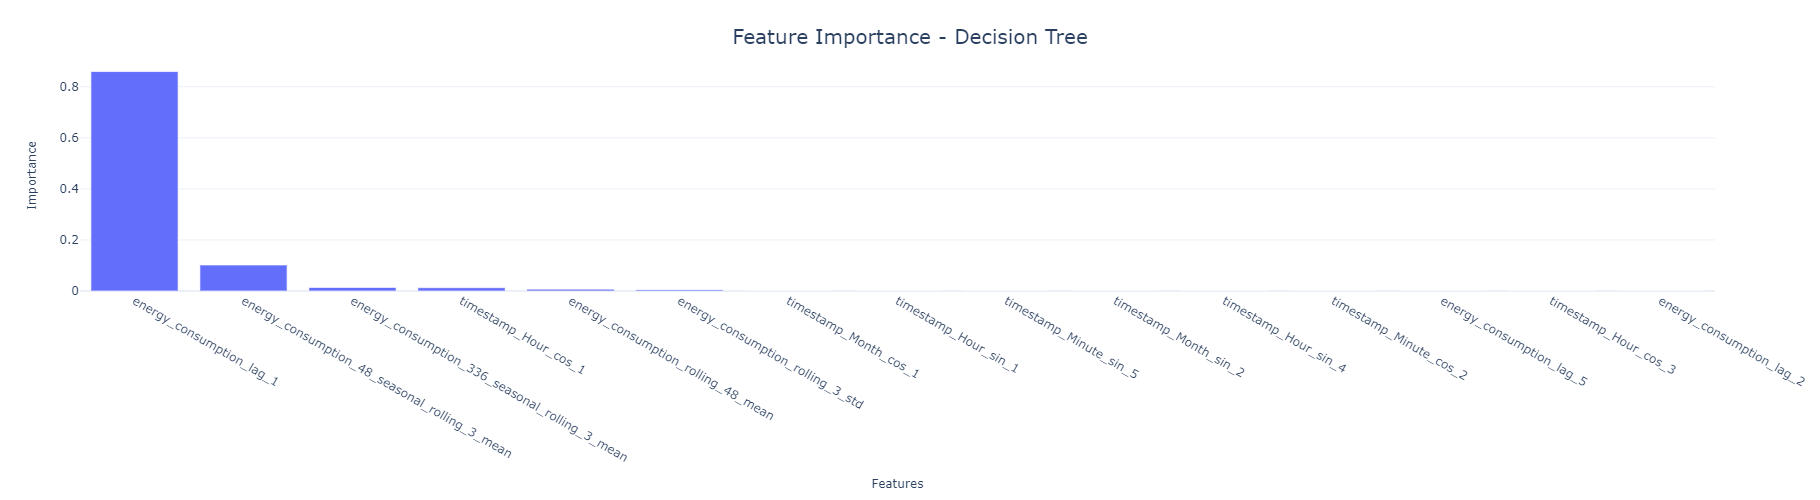

In [29]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_7/dtree_fimp.png")
fig.show()

## Bagging and Boosting Trees

### Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
model_config = ModelConfig(
    model=RandomForestRegressor(random_state=42, max_depth=4),
    name="Random Forest",
    # RandomForest is not affected by normalization
    normalize=False,
    # RandomForest in scikit-learn does not handle missing values
    fill_missing=True,
)
with LogTime() as timer:
    y_pred, metrics, feat_df = evaluate_model(
        model_config,
        feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        test_target,
    )
metrics["Time Elapsed"] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-\src\forecasting\ml_forecasting.py:255: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Time Elapsed: 22 seconds


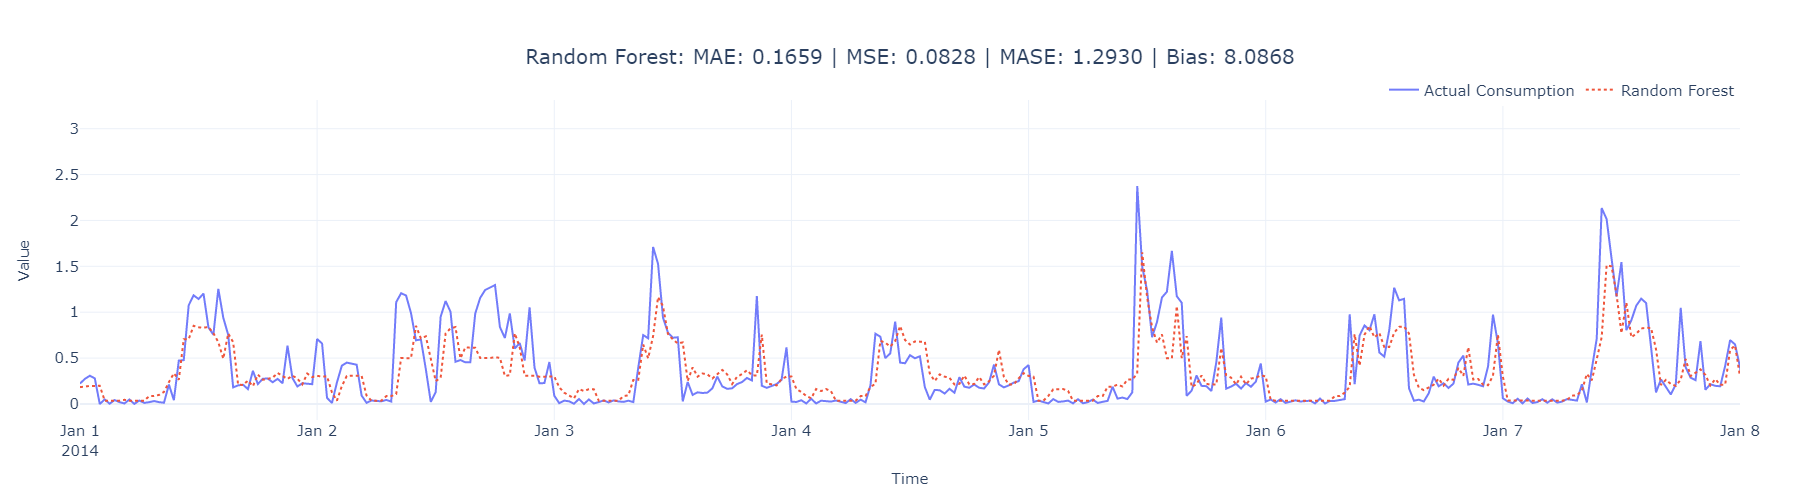

In [32]:
fig = plot_forecast(pred_df, forecast_columns=[model_config.name], forecast_display_names=[model_config.name])
fig = format_plot(fig, title=f"{model_config.name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/rf.png")
fig.show()

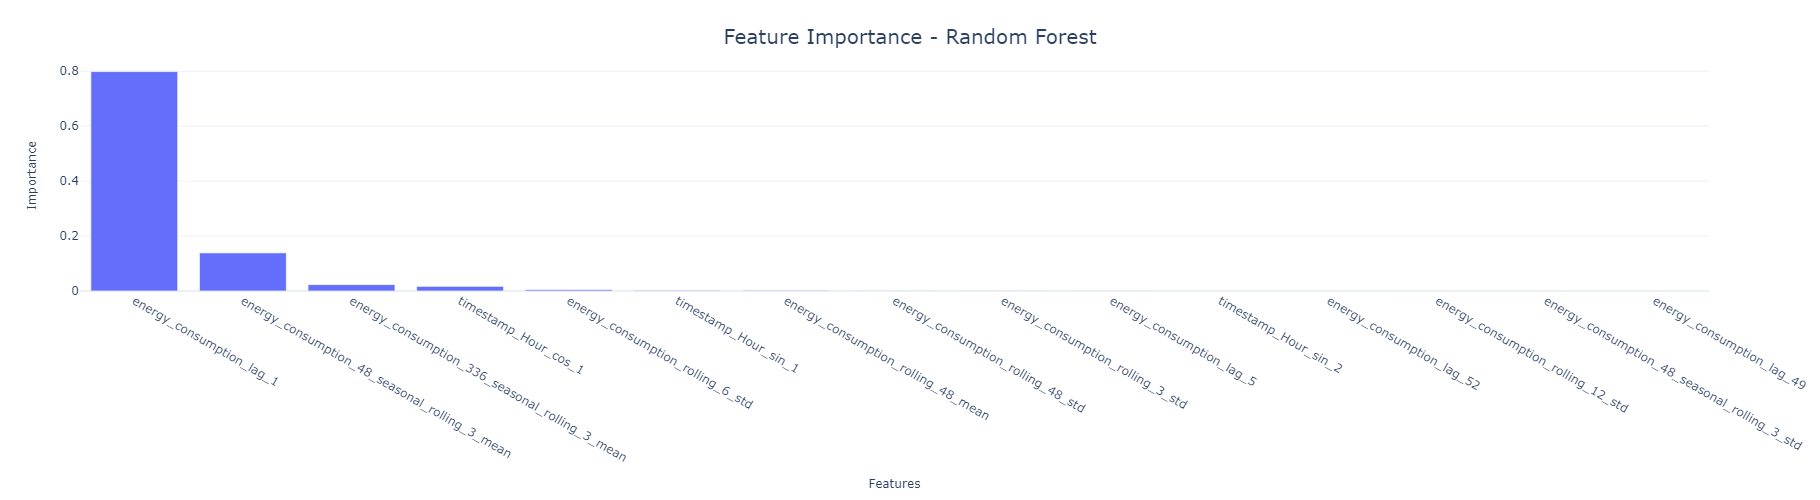

In [33]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_7/rf_fimp.png")
fig.show()

### XGBoost Random Forest

In [34]:
from xgboost import XGBRFRegressor

In [35]:
model_config = ModelConfig(
    model=XGBRFRegressor(random_state=42, max_depth=4),
    name="XGB Random Forest",
    # XGBRF is not affected by normalization
    normalize=False,
    # XGBRF handles missing values
    fill_missing=False,
)
with LogTime() as timer:
    y_pred, metrics, feat_df = evaluate_model(
        model_config,
        feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        test_target,
    )
metrics["Time Elapsed"] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 2 seconds


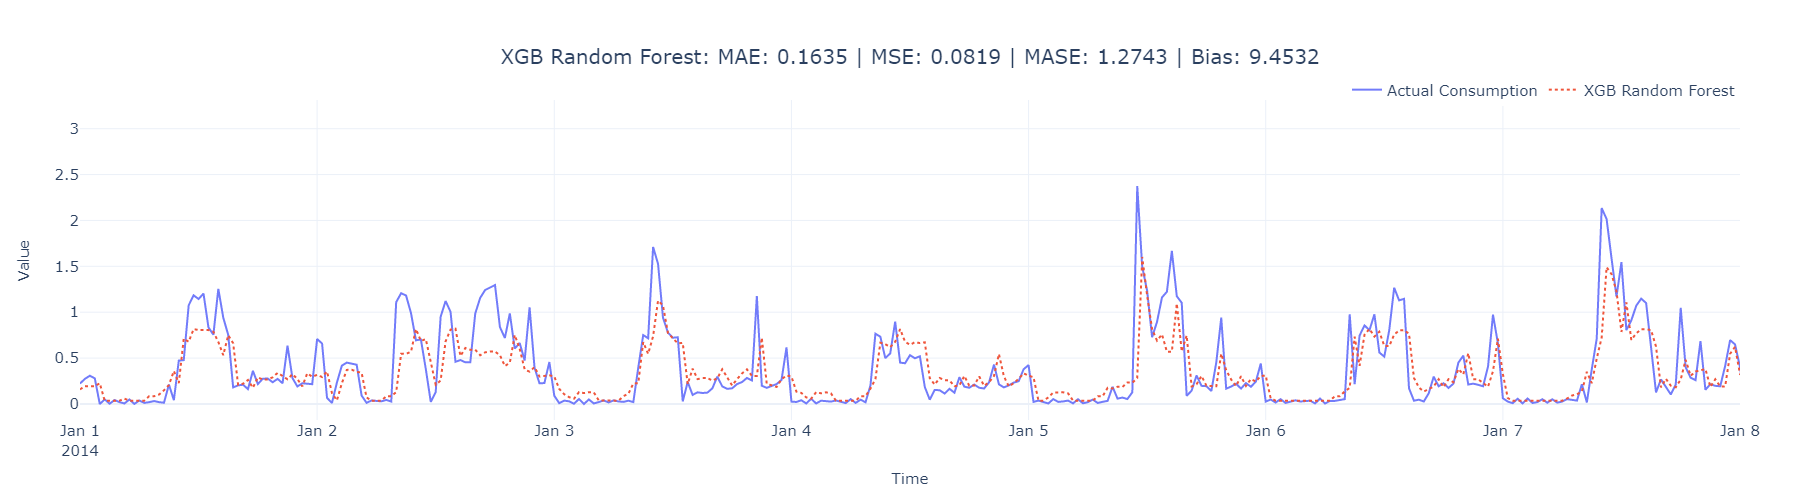

In [36]:
fig = plot_forecast(pred_df, forecast_columns=[model_config.name], forecast_display_names=[model_config.name])
fig = format_plot(fig, title=f"{model_config.name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/xgbrf.png")
fig.show()

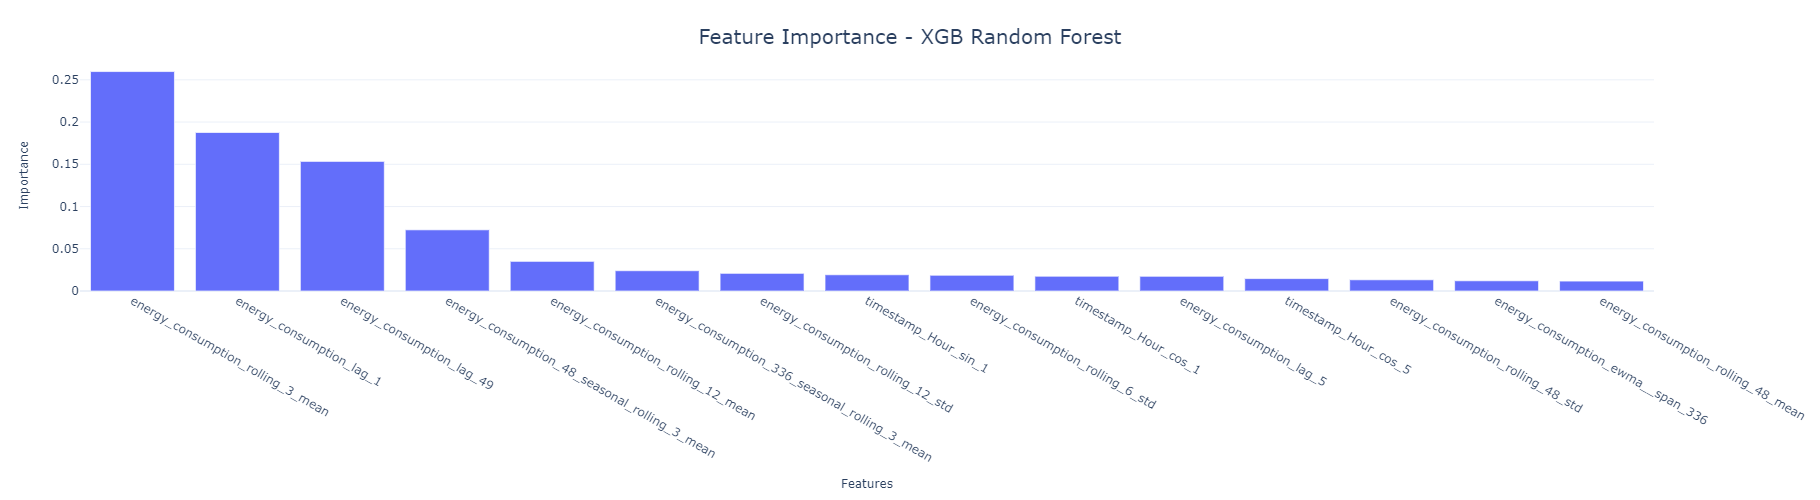

In [37]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_7/xgbrf_fimp.png")
fig.show()

### LightGBM

In [38]:
from lightgbm import LGBMRegressor

In [39]:
model_config = ModelConfig(
    model=LGBMRegressor(random_state=42),
    name="LightGBM",
    # LightGBM is not affected by normalization
    normalize=False,
    # LightGBM handles missing values
    fill_missing=False,
)
with LogTime() as timer:
    y_pred, metrics, feat_df = evaluate_model(
        model_config,
        feat_config,
        missing_value_config,
        train_features,
        train_target,
        test_features,
        test_target,
    )
metrics["Time Elapsed"] = timer.elapsed
metric_record.append(metrics)
pred_df = pred_df.join(y_pred)

Time Elapsed: 0 microseconds


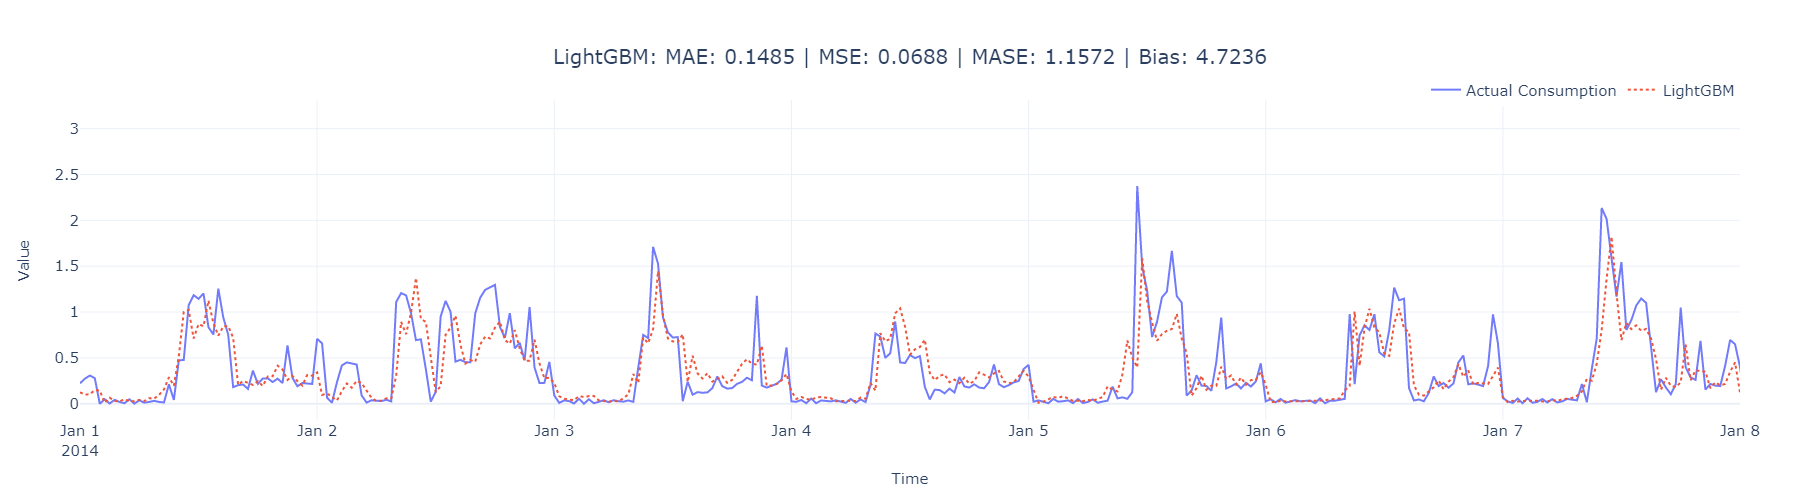

In [40]:
fig = plot_forecast(pred_df, forecast_columns=[model_config.name], forecast_display_names=[model_config.name])
fig = format_plot(fig, title=f"{model_config.name}: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image("imgs/chapter_7/lgbm.png")
fig.show()

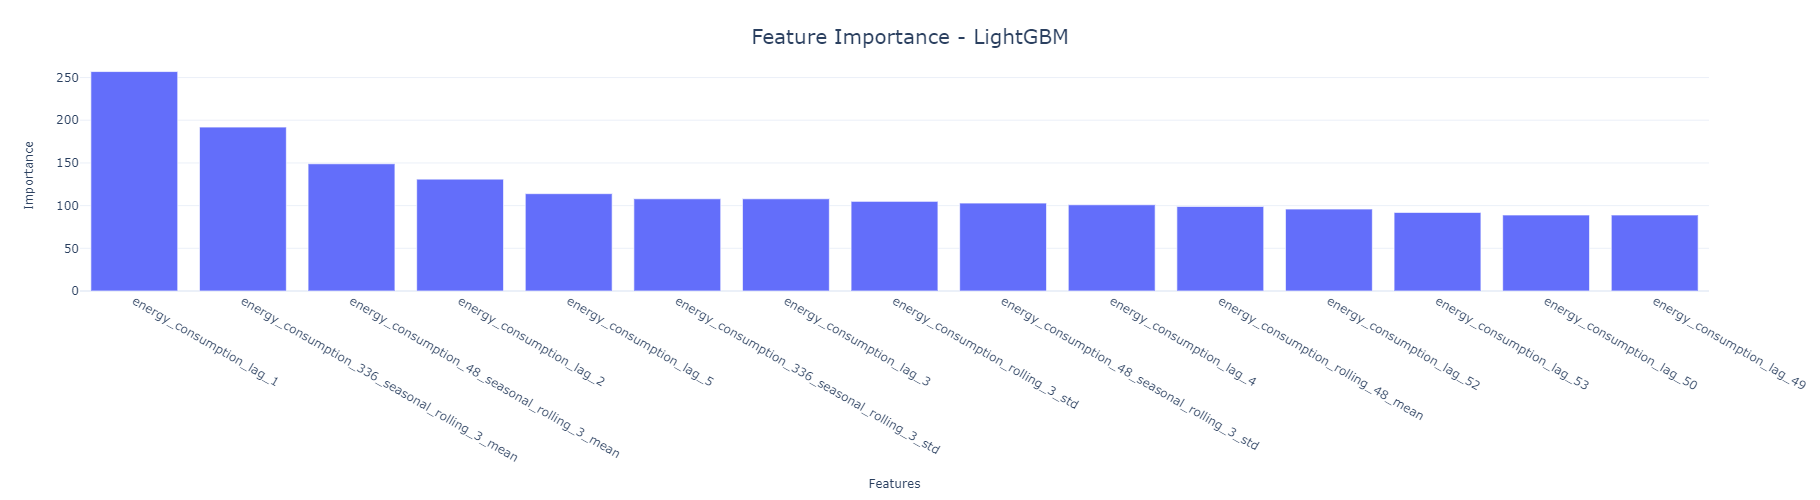

In [41]:
fig = px.bar(feat_df.head(15), x="feature", y="importance")
format_plot(fig, xlabel="Features", ylabel="Importance", title=f"Feature Importance - {model_config.name}", font_size=12)
fig.write_image("imgs/chapter_7/lgbm_fimp.png")
fig.show()

## Summary

In [49]:
def highlight_abs_min(s, props=''):
    return np.where(s == np.nanmin(np.abs(s.values)), props, '')

formatted = pd.DataFrame(metric_record).style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                          "MASE": "{:.4f}", 
                          "Forecast Bias": "{:.2f}%"})
formatted.highlight_min(color='lightgreen', subset=["MAE","MSE","MASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

# Running ML Forecast for all consumers

Running Lasso Regression, XGB Random Forest, and LightGBM

In [44]:
lcl_ids = sorted(train_df.LCLid.unique())
models_to_run = [
    ModelConfig(
        model=LassoCV(), name="Lasso Regression", normalize=True, fill_missing=True
    ),
    ModelConfig(
        model=XGBRFRegressor(random_state=42, max_depth=4),
        name="XGB Random Forest",
        normalize=False,
        fill_missing=False,
    ),
    ModelConfig(
        model=LGBMRegressor(random_state=42),
        name="LightGBM",
        normalize=False,
        fill_missing=False,
    ),
]

In [45]:
all_preds = []
all_metrics = []
# We can parallelize this loop to run this faster
for lcl_id in tqdm(lcl_ids):
    for model_config in models_to_run:
        model_config = model_config.clone()
        X_train, y_train, _ = feat_config.get_X_y(
            train_df.loc[train_df.LCLid == lcl_id, :],
            categorical=False,
            exogenous=False,
        )
        X_test, y_test, _ = feat_config.get_X_y(
            test_df.loc[test_df.LCLid == lcl_id, :], categorical=False, exogenous=False
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y_pred, metrics, feat_df = evaluate_model(
                model_config,
                feat_config,
                missing_value_config,
                X_train,
                y_train,
                X_test,
                y_test,
            )
        y_pred.name = "predictions"
        y_pred = y_pred.to_frame()
        y_pred["LCLid"] = lcl_id
        y_pred["Algorithm"] = model_config.name
        metrics["LCLid"] = lcl_id
        metrics["Algorithm"] = model_config.name
        y_pred["energy_consumption"] = y_test.values
        all_preds.append(y_pred)
        all_metrics.append(metrics)

  0%|          | 0/399 [00:00<?, ?it/s]

In [46]:
pred_df = pd.concat(all_preds)
pred_df.head()

predictions      LCLid         Algorithm  \
timestamp                                                       
2014-01-01 00:00:00     0.455804  MAC000002  Lasso Regression   
2014-01-01 00:30:00     0.471065  MAC000002  Lasso Regression   
2014-01-01 01:00:00     0.443578  MAC000002  Lasso Regression   
2014-01-01 01:30:00     0.438340  MAC000002  Lasso Regression   
2014-01-01 02:00:00     0.312908  MAC000002  Lasso Regression   

                     energy_consumption  
timestamp                                
2014-01-01 00:00:00               0.496  
2014-01-01 00:30:00               0.427  
2014-01-01 01:00:00               0.469  
2014-01-01 01:30:00               0.362  
2014-01-01 02:00:00               0.452

In [47]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df.head()

Algorithm       MAE       MSE      MASE  Forecast Bias      LCLid
0   Lasso Regression  0.106273  0.033688  0.986859      -1.154035  MAC000002
1  XGB Random Forest  0.106316  0.036078  0.987251       3.700024  MAC000002
2           LightGBM  0.094255  0.030670  0.875256      -0.096464  MAC000002
3   Lasso Regression  0.054963  0.010999  0.976263       1.052001  MAC000005
4  XGB Random Forest  0.053381  0.010729  0.948167       2.243894  MAC000005

# Evaluation of ML Forecast

In [48]:
from src.utils import ts_utils

In [49]:
baseline_aggregate_metrics_df

MAE       MSE  meanMASE  Forecast Bias
Naive           0.111043  0.054808  1.009591       0.005201
Seasonal Naive  0.175735  0.123515  1.571673       1.660885

In [50]:
metrics = baseline_aggregate_metrics_df.reset_index().rename(columns={"index":"Algorithm"}).to_dict(orient="records")

In [51]:

for model_config in models_to_run:
    pred_mask = pred_df.Algorithm==model_config.name
    metric_mask = metrics_df.Algorithm==model_config.name
    metrics.append({
    "Algorithm": model_config.name,
    "MAE": ts_utils.mae(pred_df.loc[pred_mask,"energy_consumption"], pred_df.loc[pred_mask,"predictions"]),
    "MSE": ts_utils.mse(pred_df.loc[pred_mask,"energy_consumption"], pred_df.loc[pred_mask,"predictions"]),
    "meanMASE": metrics_df.loc[metric_mask, "MASE"].mean(),
    "Forecast Bias": ts_utils.forecast_bias_aggregate(pred_df.loc[pred_mask,"energy_consumption"], pred_df.loc[pred_mask,"predictions"])
})

In [55]:
agg_metrics_df = pd.DataFrame(metrics)
agg_metrics_df.style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                          "meanMASE": "{:.4f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["MAE","MSE","meanMASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

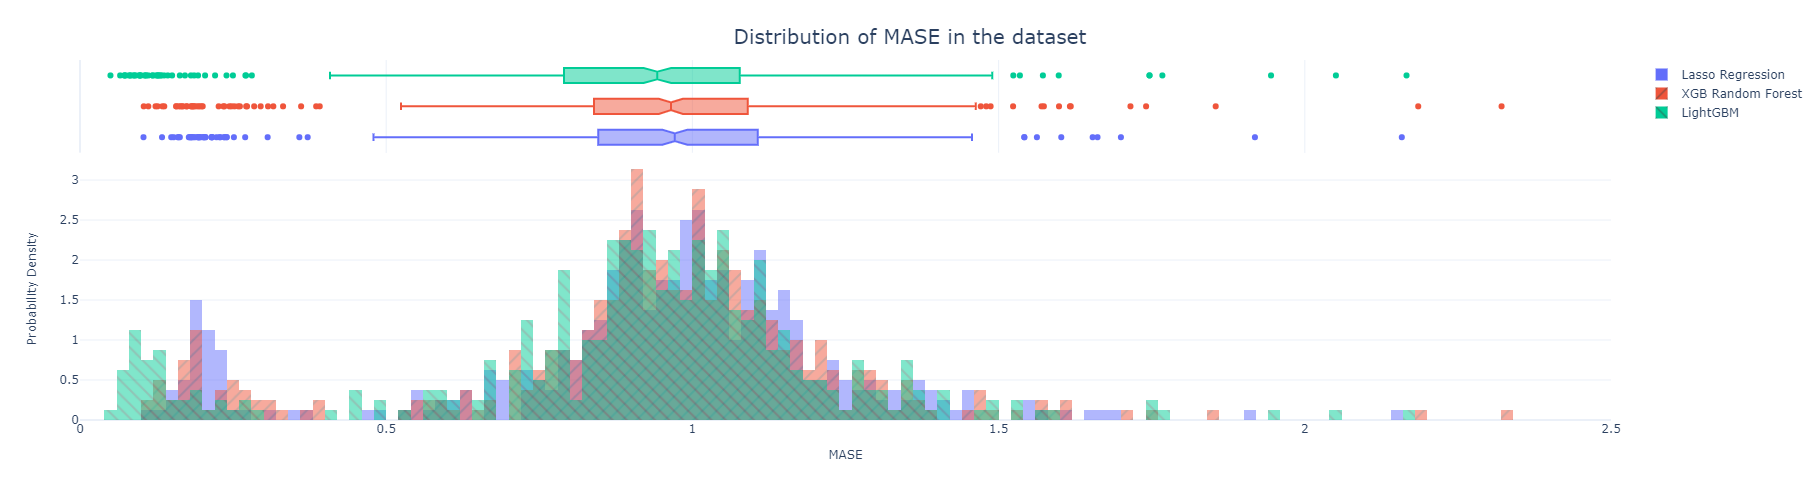

In [54]:
fig = px.histogram(metrics_df, 
                   x="MASE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MASE", ylabel="Probability Density", title="Distribution of MASE in the dataset")
fig.update_layout(xaxis_range=[0,2.5])
fig.write_image("imgs/chapter_7/mase_dist.png")
fig.show()

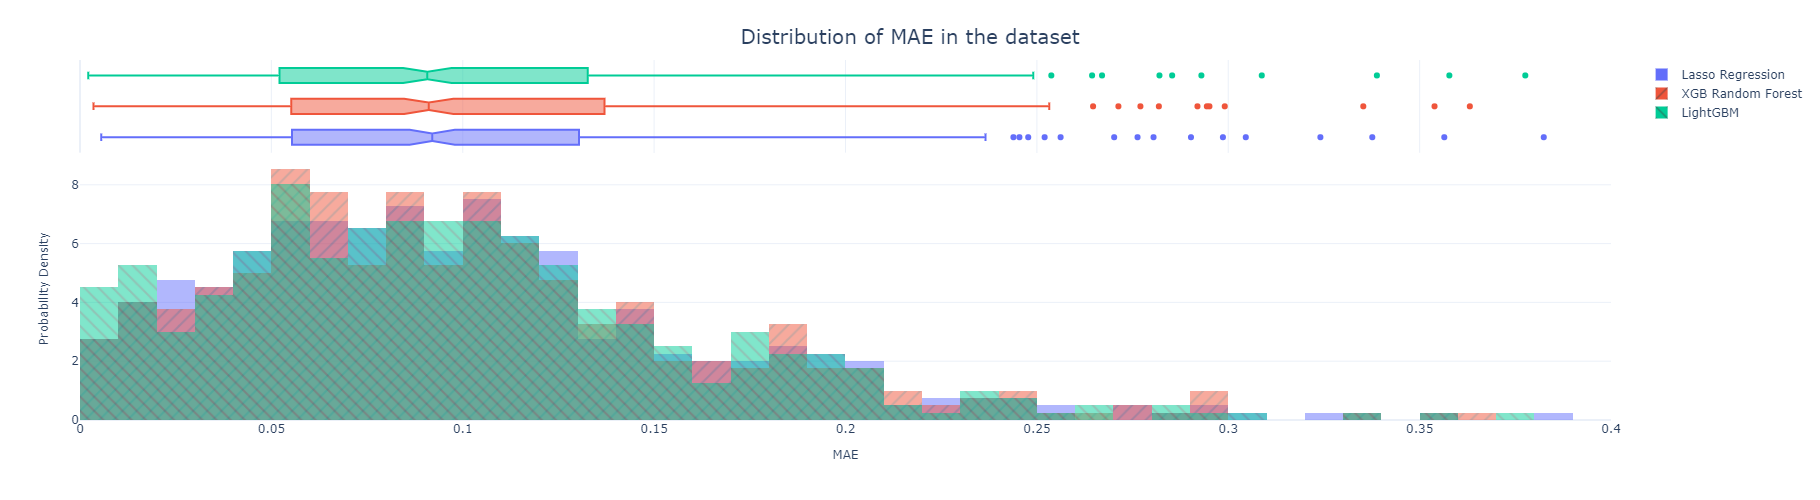

In [55]:
fig = px.histogram(metrics_df, 
                   x="MAE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=100, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MAE", ylabel="Probability Density", title="Distribution of MAE in the dataset")
fig.write_image("imgs/chapter_7/mae_dist.png")
fig.update_layout(xaxis_range=[0,0.4])
fig.show()

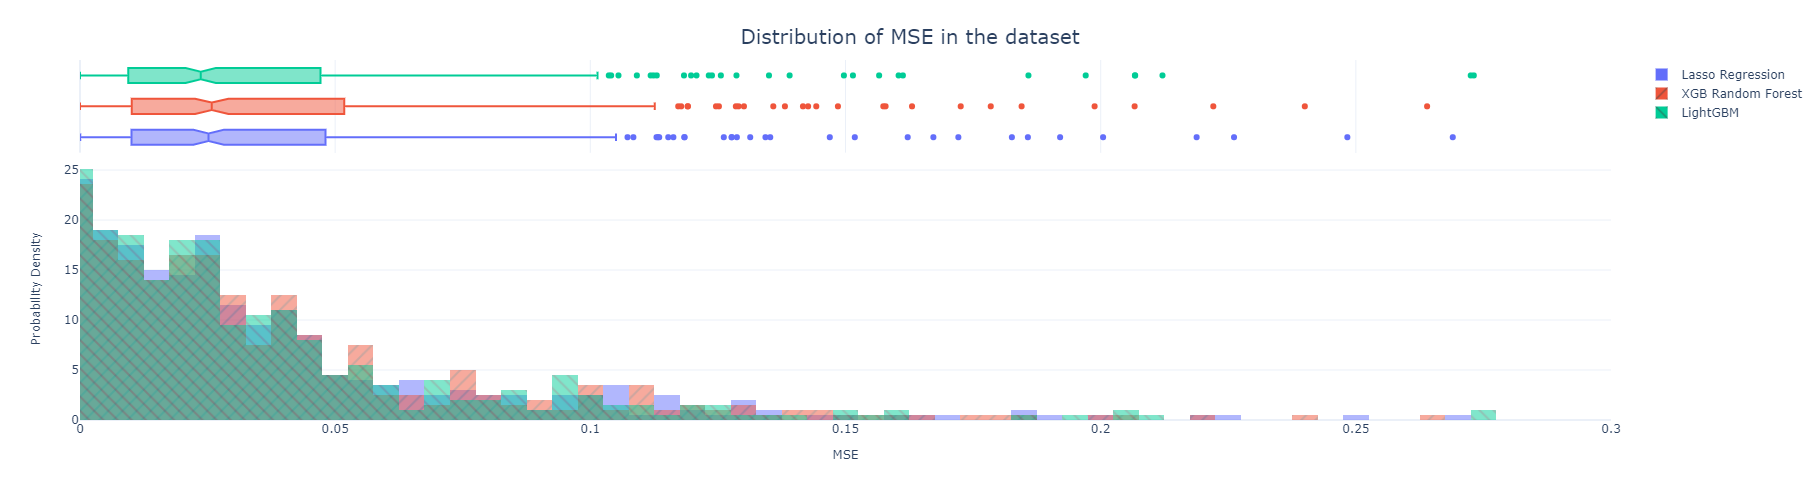

In [56]:
fig = px.histogram(metrics_df, 
                   x="MSE", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=500, 
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="MSE", ylabel="Probability Density", title="Distribution of MSE in the dataset")
fig.update_layout(xaxis_range=[0,0.3])
fig.write_image("imgs/chapter_7/mse_dist.png")
fig.show()

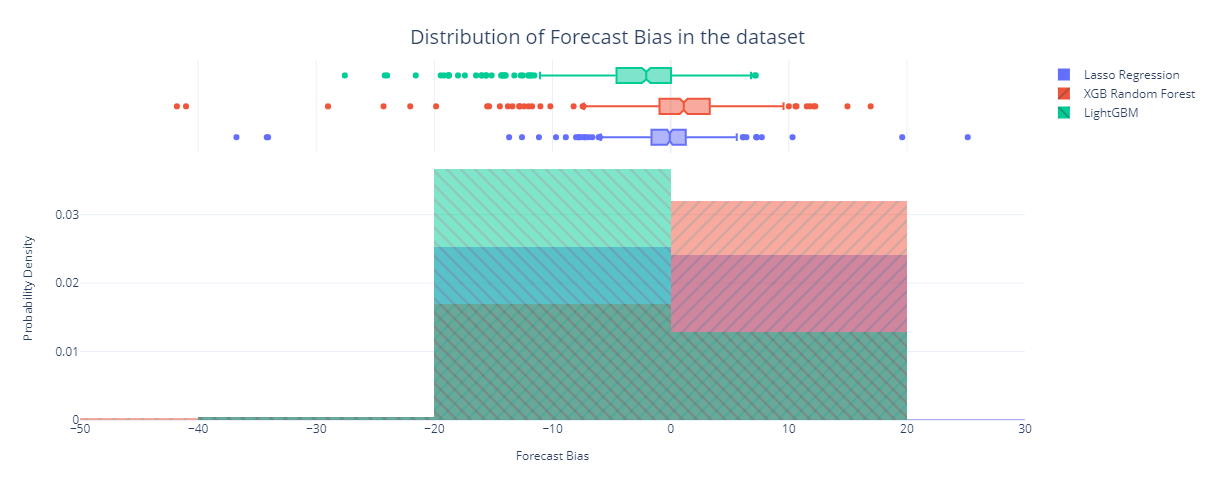

In [57]:
fig = px.histogram(metrics_df, 
                   x="Forecast Bias", 
                   color="Algorithm",
                   pattern_shape="Algorithm", 
                   marginal="box", 
                   nbins=250,
                   barmode="overlay",
                   histnorm="probability density")
fig = format_plot(fig, xlabel="Forecast Bias", ylabel="Probability Density", title="Distribution of Forecast Bias in the dataset")
fig.update_layout(xaxis_range=[-50,30])
fig.write_image("imgs/chapter_7/bias_dist.png")
fig.show()

# Saving the Baseline Forecasts and Metrics

In [53]:
os.makedirs("data/london_smart_meters/output", exist_ok=True)
output = Path("data/london_smart_meters/output")

In [54]:
pred_df.to_pickle(output/"ml_single_step_prediction_val_df.pkl")
metrics_df.to_pickle(output/"ml_single_step_metrics_val_df.pkl")
agg_metrics_df.to_pickle(output/"ml_single_step_aggregate_metrics_val.pkl")

# Bonus: Using Exogenous Variables

We can run LightGBM, which was our best performing algorithm with exogenous variables

In [60]:
lcl_ids = sorted(train_df.LCLid.unique())
models_to_run = [
    ModelConfig(model = LGBMRegressor(random_state=42), name="LightGBM", normalize=False, fill_missing=False)
]

In [61]:
from sklearn.exceptions import DataConversionWarning

In [62]:
all_preds = []
all_metrics = []
#We can parallelize this loop to run this faster
for lcl_id in tqdm(lcl_ids):
    for model_config in models_to_run:
        model_config = model_config.clone()
        X_train, y_train, _ = feat_config.get_X_y(train_df.loc[train_df.LCLid==lcl_id,:], categorical=False, exogenous=True)
        X_test, y_test, _ = feat_config.get_X_y(test_df.loc[test_df.LCLid==lcl_id,:], categorical=False, exogenous=True)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # warnings.filterwarnings("ignore",category=DataConversionWarning)
            y_pred, metrics, feat_df = evaluate_model(model_config, feat_config, missing_value_config, X_train, y_train, X_test, y_test)
        y_pred.name = "predictions"
        y_pred = y_pred.to_frame()
        y_pred['LCLid'] = lcl_id
        y_pred['Algorithm'] = model_config.name+"_w_exog"
        metrics["LCLid"] = lcl_id
        metrics["Algorithm"] = model_config.name+"_w_exog"
        y_pred['energy_consumption'] = y_test.values
        all_preds.append(y_pred)
        all_metrics.append(metrics)

  0%|          | 0/399 [00:00<?, ?it/s]

In [63]:
pred_w_ex_df = pd.concat(all_preds)
pred_w_ex_df.head()

predictions      LCLid        Algorithm  \
timestamp                                                      
2014-01-01 00:00:00     0.400441  MAC000002  LightGBM_w_exog   
2014-01-01 00:30:00     0.431136  MAC000002  LightGBM_w_exog   
2014-01-01 01:00:00     0.374716  MAC000002  LightGBM_w_exog   
2014-01-01 01:30:00     0.363467  MAC000002  LightGBM_w_exog   
2014-01-01 02:00:00     0.309072  MAC000002  LightGBM_w_exog   

                     energy_consumption  
timestamp                                
2014-01-01 00:00:00               0.496  
2014-01-01 00:30:00               0.427  
2014-01-01 01:00:00               0.469  
2014-01-01 01:30:00               0.362  
2014-01-01 02:00:00               0.452

In [64]:
metrics_w_ex_df = pd.DataFrame(all_metrics)
metrics_w_ex_df.head()

Algorithm       MAE       MSE      MASE  Forecast Bias      LCLid
0  LightGBM_w_exog  0.093617  0.029880  0.869330       0.497456  MAC000002
1  LightGBM_w_exog  0.051126  0.009047  0.908108      -3.202377  MAC000005
2  LightGBM_w_exog  0.057504  0.011443  0.865322       0.656099  MAC000017
3  LightGBM_w_exog  0.105814  0.036522  0.969737      -3.275683  MAC000030
4  LightGBM_w_exog  0.256873  0.126144  1.355786     -11.263161  MAC000040

## Evaluation of ML Forecast with Exogenous

In [65]:
from src.utils import ts_utils

In [66]:
metrics = baseline_aggregate_metrics_df.reset_index().rename(columns={"index":"Algorithm"}).to_dict(orient="records")

In [67]:
metrics.append(agg_metrics_df.iloc[4].to_dict())

In [68]:

for model_config in models_to_run:
    pred_mask = pred_w_ex_df.Algorithm==model_config.name+"_w_exog"
    metric_mask = metrics_w_ex_df.Algorithm==model_config.name+"_w_exog"
    metrics.append({
    "Algorithm": model_config.name+"_w_exog",
    "MAE": ts_utils.mae(pred_w_ex_df.loc[pred_mask,"energy_consumption"], pred_w_ex_df.loc[pred_mask,"predictions"]),
    "MSE": ts_utils.mse(pred_w_ex_df.loc[pred_mask,"energy_consumption"], pred_w_ex_df.loc[pred_mask,"predictions"]),
    "meanMASE": metrics_w_ex_df.loc[metric_mask, "MASE"].mean(),
    "Forecast Bias": ts_utils.forecast_bias_aggregate(pred_w_ex_df.loc[pred_mask,"energy_consumption"], pred_w_ex_df.loc[pred_mask,"predictions"])
})

In [69]:
agg_metrics_w_ex_df = pd.DataFrame(metrics)
agg_metrics_w_ex_df.style.format({"MAE": "{:.3f}", 
                          "MSE": "{:.3f}", 
                          "meanMASE": "{:.3f}", 
                          "Forecast Bias": "{:.2f}%"}).highlight_min(color='lightgreen', subset=["MAE","MSE","meanMASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])